In [ ]:
# Importing Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Lambda, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split as tts

In [ ]:
# Loading and Splitting Dataset
from tensorflow.keras.datasets import mnist
# Train | Val | Test = 35000 | 15000 | 10000
(x_temp, y_temp), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = tts(x_temp, y_temp, test_size=0.3, random_state=42)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
def preprocess_image(image):
    # Converting to grayscale
    grayscale_image = image

    # Contrasting Image
    contrasted_image = cv2.equalizeHist(grayscale_image)
    alpha = 1
    contrasted_image = cv2.multiply(contrasted_image, alpha)
    contrasted_image = np.clip(contrasted_image, 0, 255).astype(np.uint8)

    return contrasted_image

In [ ]:
# Preprocessing
x_train = np.array([preprocess_image(image) for image in x_train])
x_val = np.array([preprocess_image(image) for image in x_val])
x_test = np.array([preprocess_image(image) for image in x_test])

y_train = y_train.reshape((y_train.shape[0],))
y_val = y_val.reshape((y_val.shape[0],))
y_test = y_test.reshape((y_test.shape[0],))

In [ ]:
def create_pairs(images, labels):
  imagePairs = []
  labelPairs = []

  #Getting the indices of each class
  numclasses = len(np.unique(labels))
  idx_list = [np.where(labels == i)[0] for i in range(numclasses)]

  for i in range(len(images)):
    # Getting image of current index(i)
    currImage = images[i]
    # Getting label of current index(i)
    currLabel = labels[i]

    # Randomly choosing another label from the same class
    label_same = np.random.choice(idx_list[currLabel])
    # Getting corresponding image for this randomly selected label
    img_same = images[label_same]

    # Pairing current image with the random image of the same class
    imagePairs.append([currImage, img_same])
    labelPairs.append([1]) # This pair is the same

    # Getting a label from a different class
    label_diff = np.where(labels != currLabel)[0]
    # Getting corresponding image for this different label
    img_diff = images[np.random.choice(label_diff)]

    # Pairing current image with a random image of a different class
    imagePairs.append([currImage, img_diff])
    labelPairs.append([0]) # This pair is different

  return (np.array(imagePairs), np.array(labelPairs))

In [ ]:
x_train = x_train.astype("float32")
x_val = x_val.astype("float32")
x_test = x_test.astype("float32")

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

(training_pairs, training_labels) = create_pairs(x_train, y_train)
(val_pairs, val_labels) = create_pairs(x_val, y_val)
(test_pairs, test_labels) = create_pairs(x_test, y_test)

In [ ]:
def euclidean_distance(model_tensors):
  (imgA, imgB) = model_tensors
  sum_of_squared = K.sum(K.square(imgA - imgB), axis = 1, keepdims=True)
  return K.sqrt(K.maximum(sum_of_squared, K.epsilon()))

In [ ]:
def siamese_model(input_shape, embeddingDim = 48):
  input = Input(input_shape)
  x = BatchNormalization()(input)
  x = Conv2D(16, (3, 3), padding = "same", activation="tanh")(x)
  x = AveragePooling2D(pool_size=(2, 2))(x)
  x = Conv2D(32, (3, 3), padding = "same", activation="tanh")(x)
  x = AveragePooling2D(pool_size=(2, 2))(x)
  x = Flatten()(x)

  x = BatchNormalization()(x)
  x = Dense(10, activation="tanh")(x)
  embedding_network = Model(input, x)

  input_1 = Input(input_shape)
  input_2 = Input(input_shape)

  tower_1 = embedding_network(input_1)
  tower_2 = embedding_network(input_2)

  merge_layer = Lambda(euclidean_distance, output_shape=(1,))(
      [tower_1, tower_2]
  )
  normal_layer = BatchNormalization()(merge_layer)
  output_layer = Dense(1, activation="sigmoid")(normal_layer)
  siamese = Model(inputs=[input_1, input_2], outputs=output_layer)

  return siamese

In [ ]:
def contrastiveLoss(y_true, y_preds, margin=1):
  y_true = tf.cast(y_true, y_preds.dtype) # Making sure they are the same data type
  y_preds_squared = K.square(y_preds)
  margin_squared = K.square(K.maximum(margin - y_preds, 0))

  loss = K.mean((1 - y_true) * y_preds_squared + (y_true) * margin_squared)
  return loss

In [ ]:
image_shape = x_train[0].shape
model = siamese_model(image_shape)
model.compile(optimizer=Adam(0.001), loss = contrastiveLoss, metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 10)                   26766     ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

In [ ]:
training_pairs, training_labels = shuffle(training_pairs, training_labels, random_state=42)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    # Left Pair            Right Pair             Label Same/Different(1/0)
    [training_pairs[:, 0], training_pairs[:, 1]], training_labels[:],
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels[:]),
    epochs = 50,
    batch_size = 32,
    callbacks=[early_stopping]
)

Epoch 1/50
2625/2625 [==============================] - 27s 7ms/step - loss: 0.0903 - accuracy: 0.8977 - val_loss: 0.0440 - val_accuracy: 0.9463
Epoch 2/50
2625/2625 [==============================] - 18s 7ms/step - loss: 0.0272 - accuracy: 0.9657 - val_loss: 0.0239 - val_accuracy: 0.9694
Epoch 3/50
2625/2625 [==============================] - 18s 7ms/step - loss: 0.0206 - accuracy: 0.9740 - val_loss: 0.0177 - val_accuracy: 0.9774
Epoch 4/50
2625/2625 [==============================] - 17s 7ms/step - loss: 0.0184 - accuracy: 0.9764 - val_loss: 0.0169 - val_accuracy: 0.9786
Epoch 5/50
2625/2625 [==============================] - 19s 7ms/step - loss: 0.0170 - accuracy: 0.9786 - val_loss: 0.0165 - val_accuracy: 0.9781
Epoch 6/50
2625/2625 [==============================] - 17s 7ms/step - loss: 0.0154 - accuracy: 0.9805 - val_loss: 0.0159 - val_accuracy: 0.9804
Epoch 7/50
2625/2625 [==============================] - 17s 7ms/step - loss: 0.0153 - accuracy: 0.9805 - val_loss: 0.0234 - val_ac

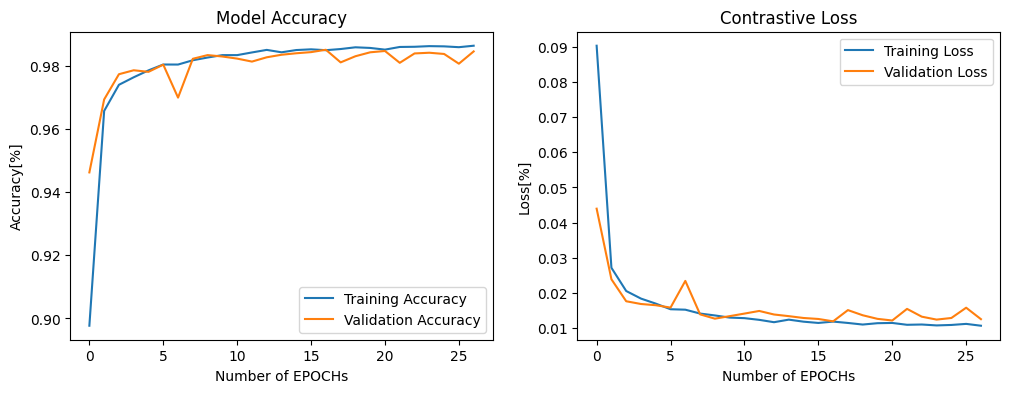

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Number of EPOCHs')
plt.ylabel('Accuracy[%]')
# plt.ylim([0.48,0.68])
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Contrastive Loss')
plt.xlabel('Number of EPOCHs')
plt.ylabel('Loss[%]')
# plt.ylim([0.2,0.26])
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels[:])

print("Test Accuracy : {:.4f}".format(test_acc))
print("Test Loss     : {:.4f}".format(test_loss))

625/625 [==============================] - 2s 3ms/step - loss: 0.0111 - accuracy: 0.9858
Test Accuracy : 0.9858
Test Loss     : 0.0111


In [ ]:
image_pairs = []
pair_distance = []
pred_labels = []
pairs = np.random.choice(len(test_pairs), size=12)
for i, idx in enumerate(pairs):
  imageA = test_pairs[idx][0]
  imageB = test_pairs[idx][1]
  label = test_labels[idx]
  pred_labels.append(label)

  combined_image = np.concatenate((imageA, imageB), axis=1)
  image_pairs.append(combined_image)

  imageA = np.expand_dims(imageA, axis=-1)
  imageB = np.expand_dims(imageB, axis=-1)

  imageA = np.expand_dims(imageA, axis=0)
  imageB = np.expand_dims(imageB, axis=0)

  predictions = model.predict([imageA, imageB])
  distance = predictions[0][0]
  pair_distance.append(distance)

1/1 [==============================] - 0s 21ms/step


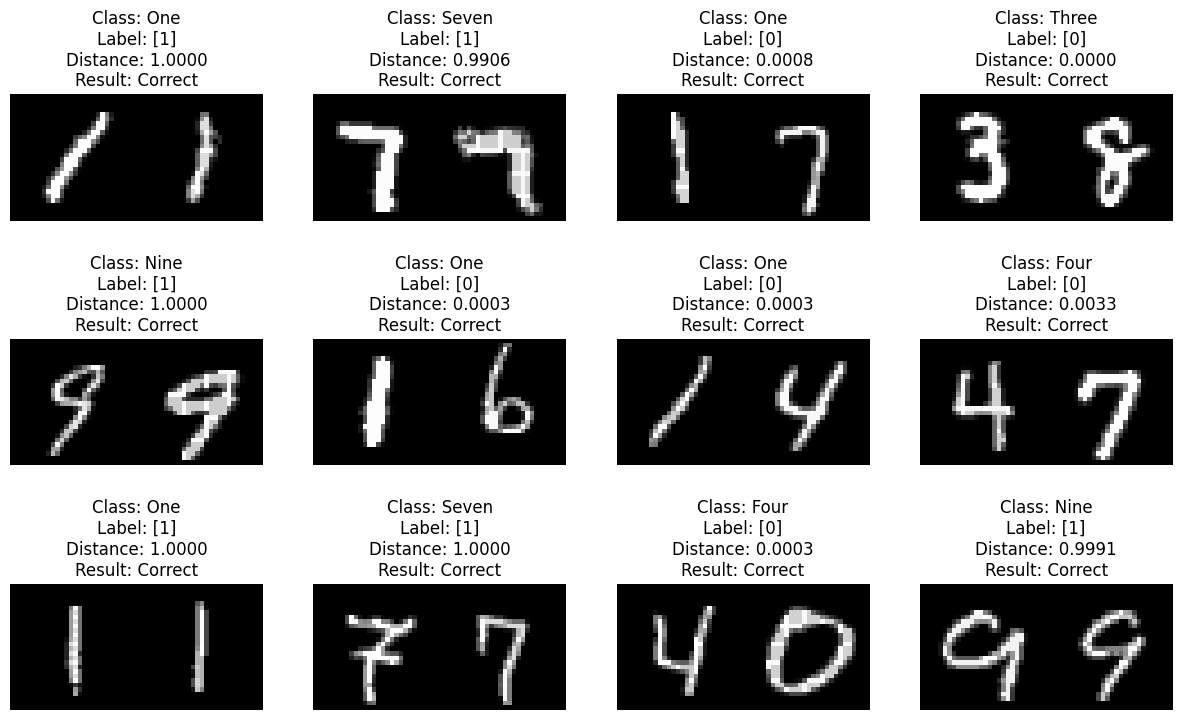

In [ ]:
label_names = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine']
plt.figure(figsize=(15,9))
total_error = 0
for i, image in enumerate(image_pairs):
  plt.subplot(3, 4, i+1)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  plt.imshow(image)
  plt.axis('off')
  error = abs(pred_labels[i]-pair_distance[i])
  total_error+=error

  # Semakin dekat value Distance dengan Label maka semakin tepat prediksi modelnya
  if(abs(pred_labels[i]-pair_distance[i]) <= 0.5):
    result = 'Correct'
  else:
    result = 'Wrong'
  plt.title("Class: {}\nLabel: {}\nDistance: {:.4f}\nResult: {}".format(label_names[y_test[int(pairs[i]/2)]], pred_labels[i], pair_distance[i], result))
plt.show()

In [ ]:
print("Predict Accuracy(MSE): {:.4f}%".format((1-total_error[0]/12)*100))

Predict Accuracy(MSE): 99.8712%
